# Workflow Observability - Part 2

## Use native instrumentation from LlamaIndex + OpenTelemetry to fine-grain tracing in your code!

In this notebook, we will go through a more complex and complete example of how to use instrumentation natively implemented in `llama-index` (combined with OpenTelemetry) to define costum span and events within your code. Before we get started:


⭐ Don'f forget to star the `llama-index-workflows` [GitHub repo](https://github.com/run-llama/workflows-py)

🦙☁ Register to [LlamaCloud](https://cloud.llamaindex.ai) not to miss out on all our awesome products

If you have feedback, questions, issues, or you just want to follow us not to miss out on any news, please find us on:

[![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/run-llama/)
[![Discord](https://img.shields.io/badge/Discord-%235865F2.svg?style=for-the-badge&logo=discord&logoColor=white)](https://discord.com/invite/eN6D2HQ4aX)
[![X](https://img.shields.io/badge/@llama__index-%23000000.svg?style=for-the-badge&logo=X&logoColor=white)](https://x.com/@llama_index)
[![Bluesky](https://img.shields.io/badge/Bluesky-0285FF?style=for-the-badge&logo=Bluesky&logoColor=white)](https://bsky.app/profile/llamaindex.bsky.social)
[![LinkedIn](https://img.shields.io/badge/linkedin-%230077B5.svg?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/company/llamaindex/)



## 1. Setting up

Before diving deep into all of this, let's install all the needed dependencies.

In [ ]:
! pip install -q llama-index-workflows llama-index-instrumentation llama-index-llms-openai llama-index-observability-otel llama-cloud-services llama-index-indices-managed-llama-cloud llama-cloud llama-index-embeddings-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.1/282.1 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 10.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


## 2. Set up OpenTelemetry

As we did in part 1, we will use the LlamaIndex integration with OpenTelemtry (`llama-index-observability-otel`) and we will create our custom `SpanExporter`. You can find many other exporters in [OpenTelemetry docs](https://opentelemetry.io/docs/languages/python/exporters/).


In [ ]:
import os
from pathlib import Path

import json

from llama_index.observability.otel import LlamaIndexOpenTelemetry
from opentelemetry.sdk.trace.export import SpanExporter, SpanExportResult
from opentelemetry.sdk.trace import ReadableSpan
from typing import Optional, Callable, Sequence
from os import linesep


class FileSpanExporter(SpanExporter):
    """Implementation of :class:`SpanExporter` that prints spans to the
    console.

    This class can be used for diagnostic purposes. It prints the exported
    spans to the console STDOUT.
    """

    def __init__(
        self,
        service_name: str | None = None,
        file_path: Optional[os.PathLike[str]] = None,
        formatter: Callable[[ReadableSpan], str] = lambda span: json.dumps(
            json.loads(span.to_json())
        )
        + linesep,
    ):
        if not file_path:
            file_path = "traces.json"
        if Path(file_path).exists():
            raise ValueError(f"File {file_path} already exists")
        self.file_path = file_path
        self.formatter = formatter
        self.service_name = service_name

    def export(self, spans: Sequence[ReadableSpan]) -> SpanExportResult:
        print(f"Writing {len(spans)} spans to {self.file_path}")
        if Path(self.file_path).exists():
            mode = "a"
        else:
            mode = "w"
        with open(self.file_path, mode) as out:
            for span in spans:
                out.write(self.formatter(span))
            out.flush()
        return SpanExportResult.SUCCESS

    def force_flush(self, timeout_millis: int = 30000) -> bool:
        return True

## 4. Instrument a workflow

Let's take our knowledge of instrumentation to the next level: it is time to use this knowledge to build and instrument a workflow!

The workflow that we want to build automates customer support e-mails by extracting important information from them, gather answers to the customers' questions from a company database, ask for feedback from a human employee and, if the feedback is positive, send the email.

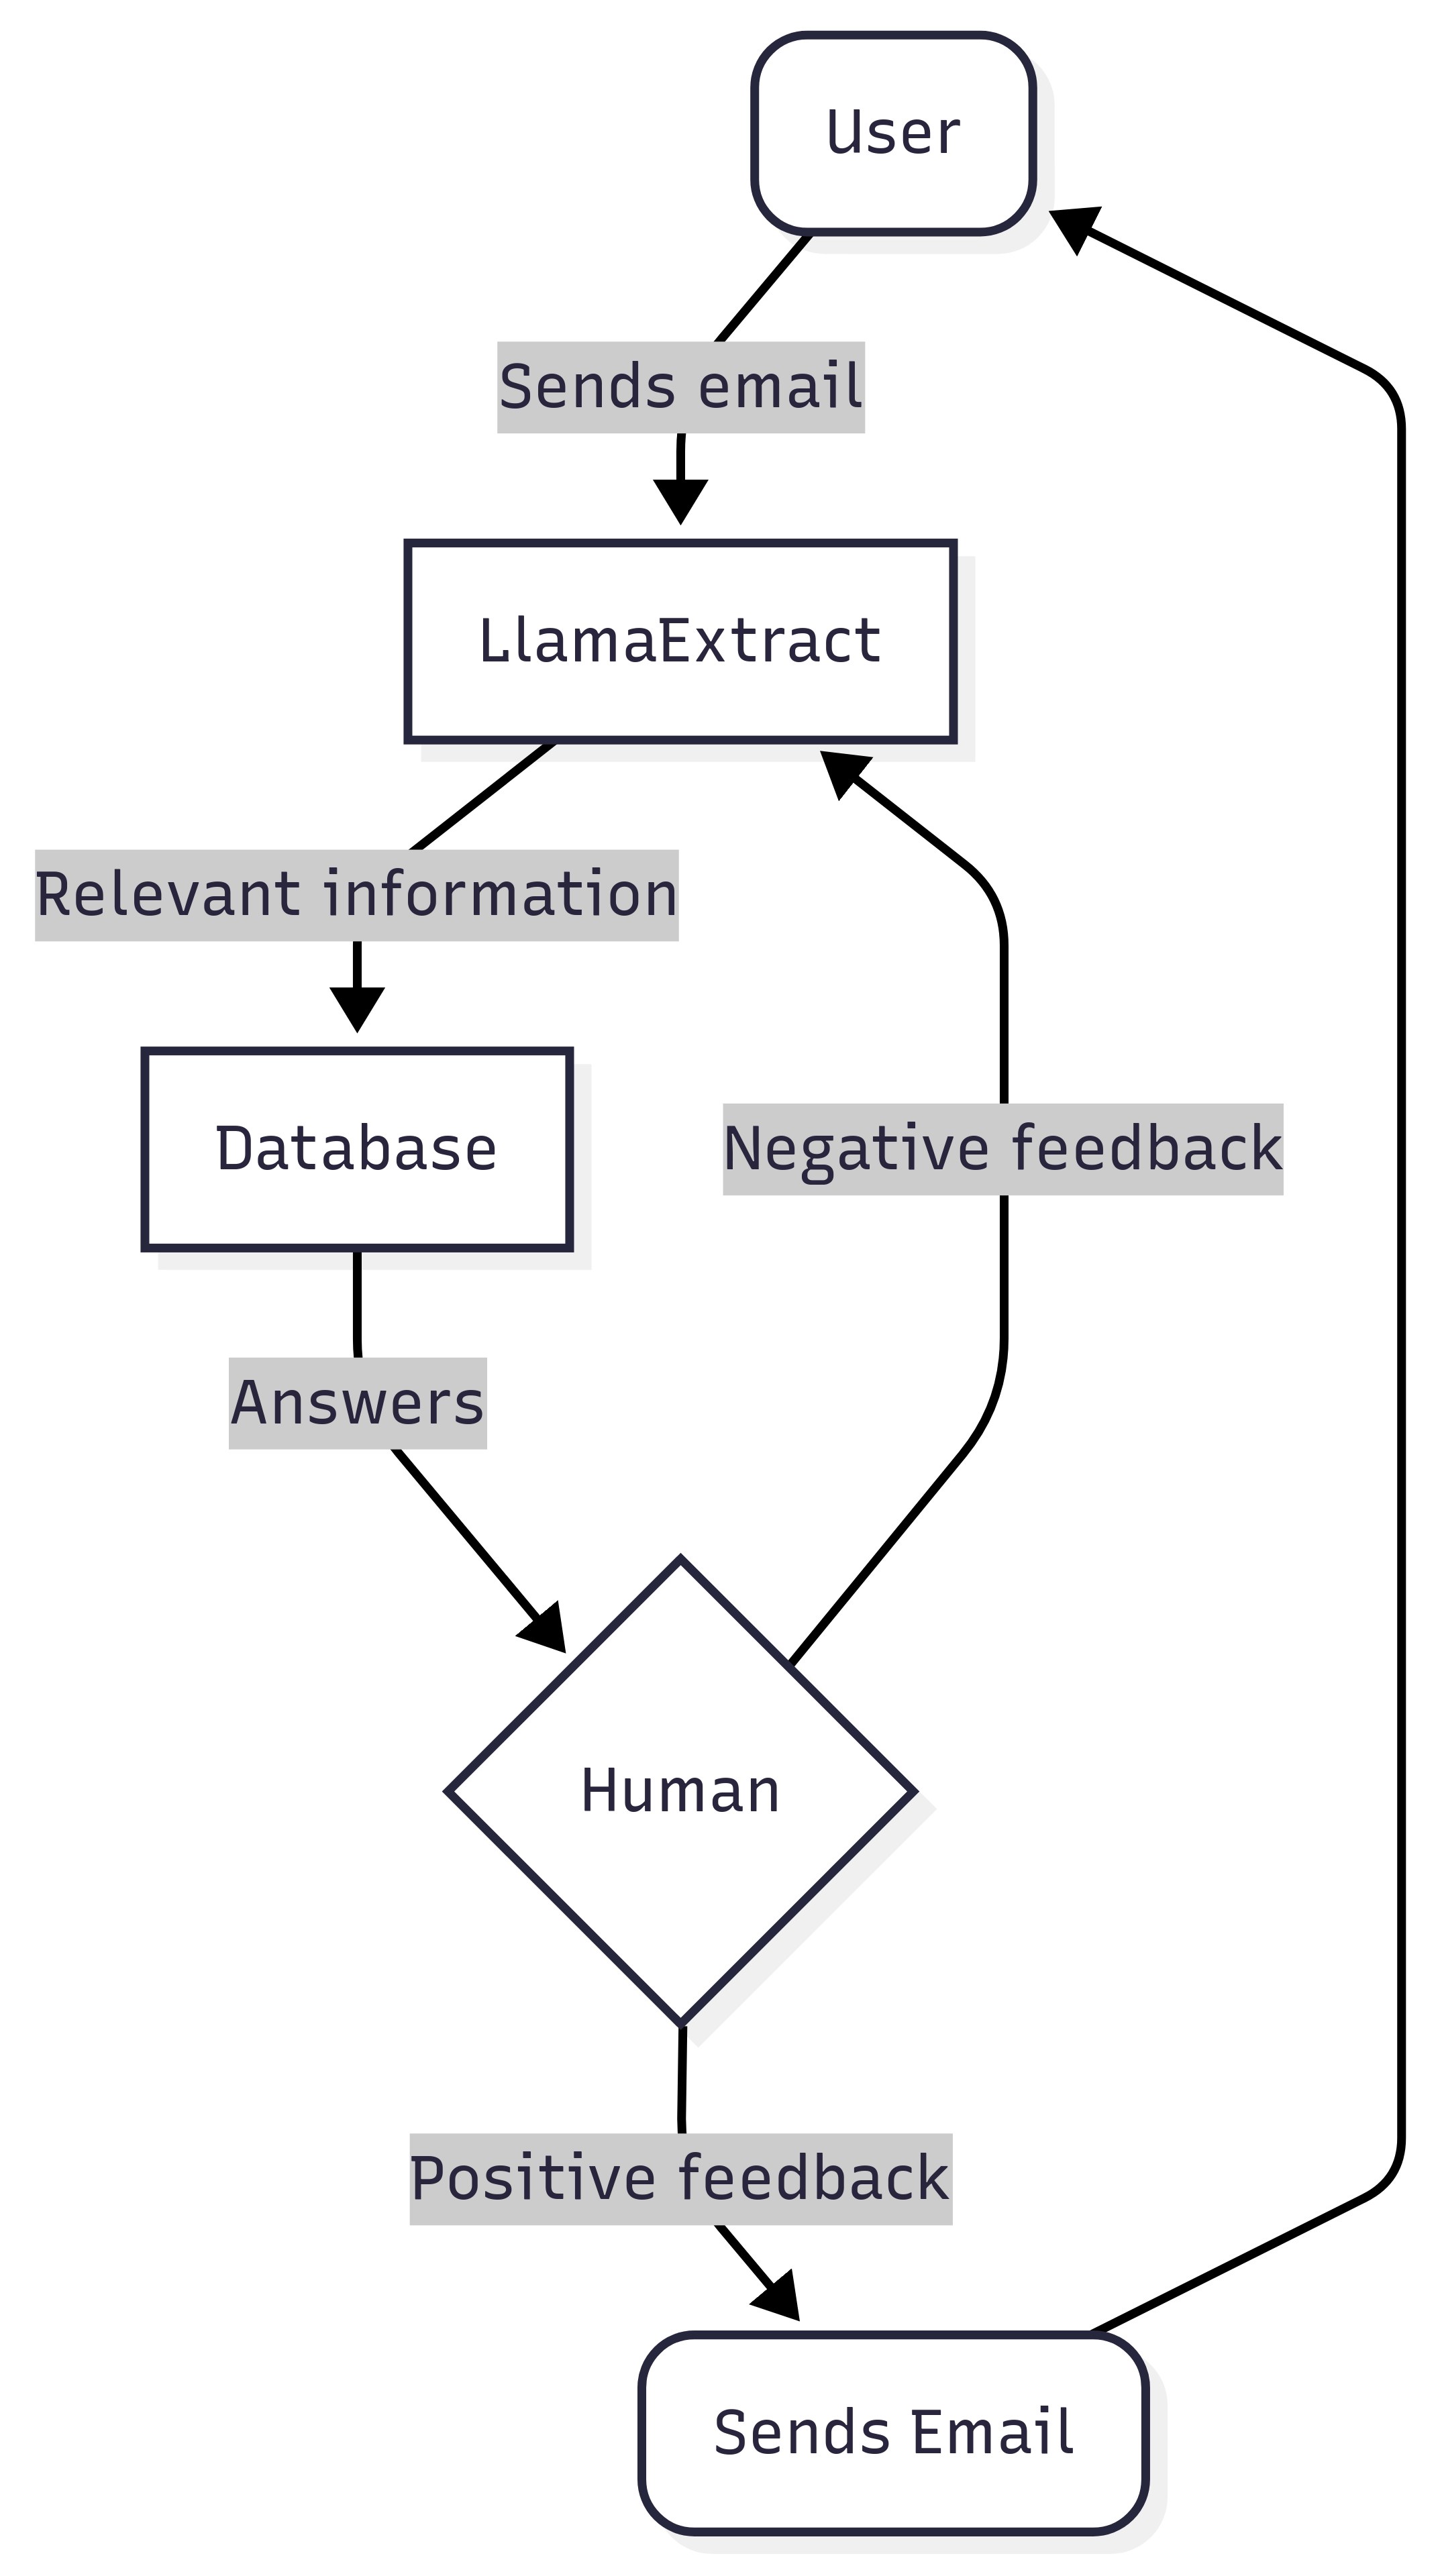

### 4.1 Define custom events

The first thing that we need to do is to define the custom event that we will us throughout our framework.

We can do it by subclassing the general `Event` classes that the `llama-index-workflows` package provides us with

In [ ]:
from workflows.events import (
    HumanResponseEvent,
    Event,
    StartEvent,
    StopEvent,
    InputRequiredEvent,
)
from typing import Literal, List, Dict


class EmailEvent(StartEvent):
    """Triggers the workflow when an e-mail is received."""

    email_content: str


class InformationExtractionEvent(Event):
    """Event that contains the extracted information from the email."""

    sender_details: str
    support_category: Literal["technical", "sales", "general_information"]
    support_questions: List[str]
    extra_information: str


class QuestionEvent(Event):
    """Event containing one or more questions to retrieve information from the company database."""

    questions: List[str]


class RetrievalEvent(Event):
    """Event that contains the retrieved information"""

    information: Dict[str, str]


class CandidateEmailEvent(InputRequiredEvent):
    """Event where we generate a candidate email to send back to the user in response to their support questions"""

    candidate_email: str


class HumanFeedbackEvent(HumanResponseEvent):
    """Ask for human feedback."""

    approved: bool
    feedback: str


class SendEmailEvent(StopEvent):
    """Event where the agent sends an email"""

    email_content: str
    email_successfully_sent: bool


class ProgressEvent(Event):
    msg: str

### 4.2 Define custom resources

[Resources](https://docs.llamaindex.ai/en/stable/understanding/workflows/resources/) are a way of performing dependency injection in workflow steps.

We will need three main resources:

1. An extraction agent to perform information extraction from the email
2. An LLM to provide us with questions to ask to the company database to retrieve information
3. The company database client to perform information retrieval

Let's first build our extraction agent:


In [ ]:
from getpass import getpass

os.environ["OPENAI_API_KEY"] = getpass()

··········


In [ ]:
os.environ["LLAMACLOUD_API_KEY"] = getpass()

··········


We need to specify a schema for the extraction first:

In [ ]:
from pydantic import BaseModel, Field


class SenderDetails(BaseModel):
    name: str = Field(description="Name of the sender seeking support")
    email_address: str = Field(description="Email address of the sender")
    company: Optional[str] = Field(
        descrption="Company for which the sender works", default=None
    )
    role: Optional[str] = Field(descrption="Job role of the sender", default=None)


class SupportEmailInformation(BaseModel):
    sender_details: SenderDetails
    support_category: Literal["technical", "sales", "general_information"]
    support_questions: List[str]
    extra_information: str

Then we create the extraction agent using `llama-cloud-services`, specifically [LlamaExtract](https://www.llamaindex.ai/llamaextract), our best-in-class platform for document extraction:

In [ ]:
from llama_cloud_services import LlamaExtract

client = LlamaExtract(api_key=os.getenv("LLAMACLOUD_API_KEY"))
agent = client.create_agent(
    name="EmailSupportAgent", data_schema=SupportEmailInformation
)
os.environ["EXTRACT_AGENT_ID"] = agent.id

Now that we created the agent, let's create a company database that we can query. We will do it using [LlamaCloud Index](https://docs.llamaindex.ai/en/stable/module_guides/indexing/llama_cloud_index/), a fully automated ingestion pipeline for our company documents.

Let's imagine that we are a company called YourBestSoftware, and we sell productivity tools for enterprise solutions.

Let's get the documents related to techinical, sales and general support for our company:

In [ ]:
! mkdir data
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_technical.pdf > data/yourbestsoftware_technical.pdf
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_sales.pdf > data/yourbestsoftware_sales.pdf
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/support/yourbestsoftware_general.pdf > data/yourbestsoftware_general.pdf

mkdir: cannot create directory ‘data’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2564k  100 2564k    0     0  5475k      0 --:--:-- --:--:-- --:--:-- 5467k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4108k  100 4108k    0     0  7445k      0 --:--:-- --:--:-- --:--:-- 7455k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4526k  100 4526k    0     0   9.9M      0 --:--:-- --:--:-- --:--:--  9.9M


Now let's upload them to a LlamaCloud Index:

In [ ]:
from llama_cloud import (
    PipelineCreateEmbeddingConfig_OpenaiEmbedding,
    PipelineTransformConfig_Advanced,
    AdvancedModeTransformConfigChunkingConfig_Sentence,
    AdvancedModeTransformConfigSegmentationConfig_Page,
)
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex


embed_model = OpenAIEmbedding(
    model="text-embedding-3-small", api_key=os.getenv("OPENAI_API_KEY")
)

index = await LlamaCloudIndex.acreate_index(
    api_key=os.getenv("LLAMACLOUD_API_KEY"),
    name="observability-demo-index",
    embedding_config=PipelineCreateEmbeddingConfig_OpenaiEmbedding(
        type="OPENAI_EMBEDDING",
        component=embed_model,
    ),
    transform_config=PipelineTransformConfig_Advanced(
        mode="advanced",
        segmentation_config=AdvancedModeTransformConfigSegmentationConfig_Page(
            mode="page"
        ),
        chunking_config=AdvancedModeTransformConfigChunkingConfig_Sentence(
            mode="sentence",
            chunk_size=1024,
            chunk_overlap=200,
            separator="<whitespace>",
            paragraph_separator="\n\n",
        ),
    ),
)

Now let's upload our files to this pipeline we just created:

In [ ]:
files: List[dict] = []
fls = [os.path.join("data", f) for f in os.listdir("data/")]

file_ids = []
for fl in fls:
    file_ids.append(await index.aupload_file(fl, wait_for_ingestion=False))

await index.wait_for_completion(file_ids=file_ids)

It will take some minutes for our pipeline to load and process all the files, so in the meantime we define the functions that would work as resources:

In [ ]:
from llama_index.indices.managed.llama_cloud import LlamaCloudIndex
from llama_index.llms.openai import OpenAIResponses
from llama_index.core.query_engine import BaseQueryEngine
from llama_cloud_services.extract.extract import ExtractionAgent
from llama_index.core.llms.structured_llm import StructuredLLM
from llama_index.core.llms import LLM
from pydantic import BaseModel, Field

llm = OpenAIResponses(model="gpt-4.1")


class SupportQuestions(BaseModel):
    questions: List[str] = Field(
        description="Support questions to ask within the company database to retrieve the most information about the users' requests"
    )


# we define a structured LLM that would give us the support questions to ask to the company database
llm_struct = llm.as_structured_llm(SupportQuestions)

query_engine = index.as_query_engine(llm=llm)


async def get_extract_agent(*args, **kwargs) -> ExtractionAgent:
    return agent


async def get_company_database(*args, **kwargs) -> BaseQueryEngine:
    return query_engine


async def get_llm(*args, **kwargs) -> StructuredLLM:
    return llm_struct


async def get_llm_for_email(*args, **kwargs) -> LLM:
    return llm

### 4.3 Create the workflow

Finally, after defining events and resources, we can create our workflow!

First we define a state where we will be storing some values during the workflow execution for persistency across steps:

In [ ]:
class WorkflowState(BaseModel):
    email_text: str = ""
    candidate_email: str = ""

In [ ]:
import uuid

from llama_index.core.llms import ChatMessage
from workflows import Workflow, Context, step
from workflows.resource import Resource
from llama_cloud_services.extract import SourceText
from typing import Annotated, Union


class EmailSupportWorkflow(Workflow):
    # remember to use the step decorator!
    @step
    async def extract_email_information(
        self,
        event: EmailEvent,
        ctx: Context[WorkflowState],
        extraction_agent: Annotated[ExtractionAgent, Resource(get_extract_agent)],
    ) -> Union[InformationExtractionEvent, SendEmailEvent]:
        extracted_content = await extraction_agent.aextract(
            files=SourceText(
                text_content=text, filename=f"support_email_{str(uuid.uuid4())}.txt"
            )
        )
        if extracted_content:
            extracted_data = SupportEmailInformation.model_validate(
                extracted_content.data
            )
            ctx.write_event_to_stream(
                ProgressEvent(msg="Information extracted successfully")
            )
            return InformationExtractionEvent(
                sender_details=extracted_data.sender_details.model_dump_json(),
                support_category=extracted_data.support_category,
                support_questions=extracted_data.support_questions,
                extra_information=extracted_data.extra_information,
            )
        ctx.write_event_to_stream(ProgressEvent(msg="Information extraction failed"))

        async with ctx.store.edit_state() as state:
            state.email_text = event.email_content

        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to extract information, please re-run the workflow",
        )

    @step
    async def generate_questions_to_ask(
        self,
        event: InformationExtractionEvent,
        ctx: Context[WorkflowState],
        llm: Annotated[StructuredLLM, Resource(get_llm)],
    ) -> Union[QuestionEvent, SendEmailEvent]:
        response = await llm.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of a support email:\n\n```json\n{event.model_dump_json()}\n```\n\nCan you please generate one or more support questions to ask to the company database to solve the users' problem?",
                )
            ]
        )
        if response.message.content:
            response_json = json.loads(response.message.content)
            ctx.write_event_to_stream(
                ProgressEvent(msg="Questions generated successfully")
            )
            return QuestionEvent(questions=response_json["questions"])
        ctx.write_event_to_stream(ProgressEvent(msg="Questions generation failed"))
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to generate questions, please re-run the workflow",
        )

    @step
    async def information_retrieval(
        self,
        event: QuestionEvent,
        ctx: Context[WorkflowState],
        company_database: Annotated[BaseQueryEngine, Resource(get_company_database)],
    ) -> RetrievalEvent:
        q_and_a: Dict[str, str] = {}
        for question in event.questions:
            response = await company_database.aquery(question)
            q_and_a.update({question: response.response or ""})
        ctx.write_event_to_stream(
            ProgressEvent(msg="Answers to questions generated successfully")
        )
        return RetrievalEvent(information=q_and_a)

    @step
    async def create_email_event(
        self,
        event: RetrievalEvent,
        ctx: Context[WorkflowState],
        llm_email: Annotated[LLM, Resource(get_llm_for_email)],
    ) -> CandidateEmailEvent:
        response = await llm_email.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of question-answer pairs for the support answers of a user:\n\n```json\n{json.dumps(event.information, indent=4)}\n```\n\nCan you please generate the text of the email to send back to the customer and answer their questions? Generate only the email.",
                )
            ]
        )
        ctx.write_event_to_stream(ProgressEvent(msg="Generated candidate email"))

        async with ctx.store.edit_state() as state:
            state.candidate_email = response.message.content

        return CandidateEmailEvent(candidate_email=response.message.content)

    @step
    async def send_email_or_restart(
        self, event: HumanFeedbackEvent, ctx: Context[WorkflowState]
    ) -> Union[SendEmailEvent, EmailEvent]:
        if event.approved:
            state = await ctx.store.get_state()
            return SendEmailEvent(
                email_content=state.candidate_email,
                email_successfully_sent=True,
                result="Email successfully sent",
            )
        else:
            state = await ctx.store.get_state()
            return EmailEvent(
                email_content=state.email_text,
            )

Now we will run the workflow as-is, an you will already see that it produces OpenTelemtry traces.

In [ ]:
# first let's get some data
! curl https://raw.githubusercontent.com/run-llama/workflows-observability-support-data/main/data/emails/general.txt > general.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1086  100  1086    0     0   5438      0 --:--:-- --:--:-- --:--:--  5457


In [ ]:
# Let's read these data

with open("general.txt", "r") as f:
    text = f.read()
text

"From: j.marino84@gmail.com  \nTo: support@yourbestsoftware.com  \nSubject: Request for General Assistance with Your Best Software Account and Features\n\nDear Support Team,\n\nI’m a fairly new user of Your Best Software and I was hoping to get some help understanding a few things related to my account and general use of the platform.\n\nI’m not encountering a specific error, but I’ve run into some confusion around how certain features are meant to work. In particular, I’d appreciate some guidance on:\n\n- Navigating between different areas of the dashboard (some settings and tools seem to be nested in ways I can’t always find easily)\n- Understanding which features are included in my current subscription level\n- General best practices for setting up my workspace to get the most out of the platform\n\nAny documentation, tips, or pointers to the right support resources would be very helpful. If there's someone I can speak with directly or a walkthrough available, that would be even bet

In [ ]:
se = FileSpanExporter(file_path="workflow_traces.json")

instrumentor = LlamaIndexOpenTelemetry(
    span_exporter=se,
    service_name_or_resource="tracing.a.workflow.1",
)

instrumentor.start_registering()

In [ ]:
wf = EmailSupportWorkflow(timeout=800)

handler = wf.run(start_event=EmailEvent(email_content=text))
async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg, flush=True)
    elif isinstance(ev, CandidateEmailEvent):
        print(f"Candidate email: {ev.candidate_email}", flush=True)
        approved = input("Approve? (y/<reason>): ").strip().lower()
        print(f"Approved? {approved}", flush=True)
        if approved == "y":
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=True, feedback="Approved")
            )
        else:
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=False, feedback=approved)
            )

result = await handler

Extracting files:   0%|          | 0/1 [00:00<?, ?it/s]

Writing 4 spans to workflow_traces.json


Extracting files: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

Information extracted successfully


Writing 4 spans to workflow_traces.json
Questions generated successfully
Writing 11 spans to workflow_traces.json
Writing 10 spans to workflow_traces.json
Writing 10 spans to workflow_traces.json
Answers to questions generated successfully
Writing 18 spans to workflow_traces.json
Generated candidate email
Candidate email: Subject: Answers to Your Support Questions

Dear [Customer Name],

Thank you for reaching out with your questions. Please find detailed answers below to help you get the most out of your platform experience:

**1. Documentation and Tutorials for New Users**  
New users have access to a wide range of resources to help navigate the dashboard, including step-by-step Getting Started Guides, comprehensive user manuals, and feature documentation. We also offer a video library with over 200 on-demand training videos, interactive in-app tutorials, and live or on-demand webinars for detailed walkthroughs. Our knowledge base provides troubleshooting guides and integration instr

In [ ]:
print(result.email_content)
print(result.email_successfully_sent)
print(result.result)

Subject: Answers to Your Support Questions

Dear [Customer Name],

Thank you for reaching out with your questions. Please find detailed answers below to help you get the most out of your platform experience:

**1. Documentation and Tutorials for New Users**  
New users have access to a wide range of resources to help navigate the dashboard, including step-by-step Getting Started Guides, comprehensive user manuals, and feature documentation. We also offer a video library with over 200 on-demand training videos, interactive in-app tutorials, and live or on-demand webinars for detailed walkthroughs. Our knowledge base provides troubleshooting guides and integration instructions, while the community forum is available for sharing best practices and asking questions. For hands-on practice, sandbox accounts are also available.

**2. Features Included in Your Current Subscription**  
Your current subscription includes:
- 24/7/365 support with a dedicated account manager
- Priority support, cu

As you can see from the output of the cell where we executed the workflow, our OpenTelemtry instrumentation has wrote several spans to the traces file. We can confirm by printing the last ten records out:

In [ ]:
with open("workflow_traces.json", "r") as f:
    lines = f.readlines()
    for line in lines[-10:]:
        print(json.dumps(json.loads(line), indent=4))

{
    "name": "CompactAndRefine.aget_response-480348a5-76cf-4cae-8e6f-8c2435e7f4c6",
    "context": {
        "trace_id": "0x39d8e6e5961a74a286c7015e272ee118",
        "span_id": "0x0163c16cbfacd645",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": "0x34c58f5c763e9447",
    "start_time": "2025-07-04T16:27:07.068699Z",
    "end_time": "2025-07-04T16:27:08.579093Z",
    "status": {
        "status_code": "OK"
    },
    "attributes": {},
    "events": [],
    "links": [],
    "resource": {
        "attributes": {
            "service.name": "tracing.a.workflow.1"
        },
        "schema_url": ""
    }
}
{
    "name": "BaseSynthesizer.asynthesize-d5567626-3114-4b5e-9a24-bed0144a9d01",
    "context": {
        "trace_id": "0x39d8e6e5961a74a286c7015e272ee118",
        "span_id": "0x34c58f5c763e9447",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": "0xee177fb17b7abfd2",
    "start_time": "2025-07-04T16:27:07.068144Z

As we saw in Part 1, we could also create a workflow that has customized events - in this case we'll create more, so that we can add them to every step of the workflow and see that they are placed within the specific span that the step emits. As for Part 1, we will not use the `@dispatcher.span` decorator since all workflow steps are already instrumented.

In [ ]:
from llama_index_instrumentation.base import BaseEvent
from llama_index_instrumentation import get_dispatcher

dispatcher = get_dispatcher()


class WorkflowEmailEvent(BaseEvent):
    email_len: int


class WorkflowExtractionEvent(BaseEvent):
    extraction_latency: float


class WorkflowQuestionsEvent(BaseEvent):
    questions_number: int


class WorkflowAnswersEvent(BaseEvent):
    q_and_a_latency: float


class WorkflowDoneEvent(BaseEvent):
    error: bool


class WorkflowCandidateEmailEvent(BaseEvent):
    candidate_email_len: int

In [ ]:
import json
import time

from workflows import Workflow, Context, step
from workflows.resource import Resource
from typing import Annotated, Union


class EmailSupportWorkflow(Workflow):
    # remember to use the step decorator!
    @step
    async def extract_email_information(
        self,
        event: EmailEvent,
        ctx: Context[WorkflowState],
        extraction_agent: Annotated[ExtractionAgent, Resource(get_extract_agent)],
    ) -> Union[InformationExtractionEvent, SendEmailEvent]:
        async with ctx.store.edit_state() as state:
            state.email_text = event.email_content

        st = time.time()
        extracted_content = await extraction_agent.aextract(
            files=SourceText(
                text_content=text, filename=f"support_email_{str(uuid.uuid4())}.txt"
            )
        )
        end = time.time()
        latency = end - st
        if extracted_content:
            extracted_data = SupportEmailInformation.model_validate(
                extracted_content.data
            )
            ctx.write_event_to_stream(
                ProgressEvent(msg="Information extracted successfully")
            )
            dispatcher.event(
                event=WorkflowEmailEvent(email_len=len(event.email_content))
            )
            dispatcher.event(event=WorkflowExtractionEvent(extraction_latency=latency))
            return InformationExtractionEvent(
                sender_details=extracted_data.sender_details.model_dump_json(),
                support_category=extracted_data.support_category,
                support_questions=extracted_data.support_questions,
                extra_information=extracted_data.extra_information,
            )
        ctx.write_event_to_stream(ProgressEvent(msg="Information extraction failed"))
        dispatcher.event(event=WorkflowDoneEvent(error=True))
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to extract information, please re-run the workflow",
        )

    @step
    async def generate_questions_to_ask(
        self,
        event: InformationExtractionEvent,
        ctx: Context[WorkflowState],
        llm: Annotated[StructuredLLM, Resource(get_llm)],
    ) -> Union[QuestionEvent, SendEmailEvent]:
        response = await llm.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of a support email:\n\n```json\n{event.model_dump_json()}\n```\n\nCan you please generate one or more support questions to ask to the company database to solve the users' problem?",
                )
            ]
        )
        if response.message.content:
            response_json = json.loads(response.message.content)
            ctx.write_event_to_stream(
                ProgressEvent(msg="Questions generated successfully")
            )
            dispatcher.event(
                event=WorkflowQuestionsEvent(
                    questions_number=len(response_json["questions"])
                )
            )
            return QuestionEvent(questions=response_json["questions"])
        ctx.write_event_to_stream(ProgressEvent(msg="Questions generation failed"))
        dispatcher.event(event=WorkflowDoneEvent(error=True))
        return SendEmailEvent(
            email_content="",
            email_successfully_sent=False,
            result="Failed to generate questions, please re-run the workflow",
        )

    @step
    async def information_retrieval(
        self,
        event: QuestionEvent,
        ctx: Context[WorkflowState],
        company_database: Annotated[BaseQueryEngine, Resource(get_company_database)],
    ) -> RetrievalEvent:
        q_and_a: Dict[str, str] = {}
        st = time.time()
        for question in event.questions:
            response = await company_database.aquery(question)
            q_and_a.update({question: response.response or ""})
        end = time.time()
        ctx.write_event_to_stream(
            ProgressEvent(msg="Answers to questions generated successfully")
        )
        dispatcher.event(event=WorkflowAnswersEvent(q_and_a_latency=end - st))
        return RetrievalEvent(information=q_and_a)

    @step
    async def create_email_event(
        self,
        event: RetrievalEvent,
        ctx: Context[WorkflowState],
        llm_email: Annotated[LLM, Resource(get_llm_for_email)],
    ) -> CandidateEmailEvent:
        response = await llm_email.achat(
            messages=[
                ChatMessage(
                    role="user",
                    content=f"Starting from this JSON representation of question-answer pairs for the support answers of a user:\n\n```json\n{json.dumps(event.information, indent=4)}\n```\n\nCan you please generate the text of the email to send back to the customer and answer their questions? Generate only the email.",
                )
            ]
        )
        ctx.write_event_to_stream(ProgressEvent(msg="Generated candidate email"))

        async with ctx.store.edit_state() as state:
            state.candidate_email = response.message.content

        dispatcher.event(
            event=WorkflowCandidateEmailEvent(
                candidate_email_len=len(response.message.content)
            )
        )
        return CandidateEmailEvent(candidate_email=response.message.content)

    @step
    async def send_email_or_restart(
        self, event: HumanFeedbackEvent, ctx: Context[WorkflowState]
    ) -> Union[SendEmailEvent, EmailEvent]:
        if event.approved:
            state = await ctx.store.get_state()
            dispatcher.event(event=WorkflowDoneEvent(error=False))
            return SendEmailEvent(
                email_content=state.candidate_email,
                email_successfully_sent=True,
                result="Email successfully sent",
            )
        else:
            state = await ctx.store.get_state()
            dispatcher.event(event=WorkflowEmailEvent(email_len=len(state.email_text)))
            return EmailEvent(
                email_content=state.email_text,
            )

In [ ]:
# Let's re-run the custom instrumented workflow

wf = EmailSupportWorkflow(timeout=800)

handler = wf.run(start_event=EmailEvent(email_content=text))
async for ev in handler.stream_events():
    if isinstance(ev, ProgressEvent):
        print(ev.msg, flush=True)
    elif isinstance(ev, CandidateEmailEvent):
        print(f"Candidate email: {ev.candidate_email}", flush=True)
        approved = input("Approve? (y/<reason>): ").strip().lower()
        print(f"Approved? {approved}", flush=True)
        if approved == "y":
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=True, feedback="Approved")
            )
        else:
            handler.ctx.send_event(
                HumanFeedbackEvent(approved=False, feedback=approved)
            )

result = await handler

Extracting files:   0%|          | 0/1 [00:00<?, ?it/s]

Writing 4 spans to workflow_traces.json


Extracting files: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]

Information extracted successfully


Questions generated successfully
Writing 15 spans to workflow_traces.json
Writing 10 spans to workflow_traces.json
Answers to questions generated successfully
Writing 18 spans to workflow_traces.json
Generated candidate email
Candidate email: Subject: Welcome! Resources and Guides for New Users

Hi [Customer Name],

Thank you for reaching out with your questions about getting started and making the most of our platform. I’m happy to provide the information you need:

**1. Documentation and Onboarding Guides:**  
New users have access to a variety of resources to help you navigate the dashboard and locate settings and tools. These include:
- A Getting Started Guide with step-by-step setup instructions
- A comprehensive User Manual
- Video tutorials with visual walkthroughs
- Interactive tutorials for in-app guided learning
- A knowledge base with feature documentation and troubleshooting guides
- Downloadable templates
- Live webinars and on-demand training modules
- A community forum f

If we now print records from `workflow_traces.json`, we will see that the tracer has registered also our custom spans. For example, we can see the `WorkflowExtractionEvent` spans:

In [ ]:
def has_extraction_latency_attribute(data: dict) -> bool:
    for event in data.get("events", []):
        if "extraction_latency" in event.get("attributes", {}):
            return True
    return False


with open("workflow_traces.json", "r") as f:
    lines = f.readlines()
    for line in lines:
        data = json.loads(line)
        if has_extraction_latency_attribute(data):
            print(json.dumps(data, indent=4))
            break

{
    "name": "EmailSupportWorkflowInst.extract_email_information-a705e6ce-ae61-42ca-852e-c0b89c4cab8c",
    "context": {
        "trace_id": "0x1624a32351233b4d8c1ae6f0217fa7a7",
        "span_id": "0xdd9813577a2fa2a4",
        "trace_state": "[]"
    },
    "kind": "SpanKind.INTERNAL",
    "parent_id": "0xd2996fdeef100e39",
    "start_time": "2025-07-04T16:52:19.057441Z",
    "end_time": "2025-07-04T16:52:26.024419Z",
    "status": {
        "status_code": "OK"
    },
    "attributes": {},
    "events": [
        {
            "name": "BaseEvent",
            "timestamp": "2025-07-04T16:52:26.024378Z",
            "attributes": {
                "id_": "c8ac716e-5be5-4cf2-bc16-8d195216022a",
                "span_id": "EmailSupportWorkflowInst.extract_email_information-a705e6ce-ae61-42ca-852e-c0b89c4cab8c",
                "email_len": 1076,
                "class_name": "BaseEvent"
            }
        },
        {
            "name": "BaseEvent",
            "timestamp": "2025-07-

As you can see, in this case we have a span with two events, corresponding exactly to the workflow step where we emit both the `WorkflowEmailEvent` and the `WorkflowExtractionEvent`

And this is all for our advanced observability demo: let us know if you have any more questions and don't forget to star the [LlamaIndex workflows repo](https://github.com/run-llama/workflows-py)🦙🚀